### **Yuang Chen, Siraaj Singh Monga, Ella Ren, Greg Satchell Jr**

In [27]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8)


## **Predicting the Chances of a Stroke Report**

### **Introduction:**

Strokes, often referred to as brain attacks, occur when blood clots block the blood supply to part of the brain (ischemic stroke). They can also occur when blood vessels in the brain burst (hemorrhagic stroke). It is imperative that strokes are met with immediate treatment to prevent brain damage and death. Strokes remain the second leading cause of death and cause a majority of disabilities worldwide (Katan & Luft, 2018). Here in Canada, strokes have risen to an occurrence rate of 108,707 per year - or roughly one every five minutes (Stroke in Canada is on the rise, 2022).

With this in mind, our research question is the following: How effective are the variables age, bmi, and avg_glucose_level at correctly predicting whether or not an individual is at risk of suffering a stroke? We intend on creating a classification model that will address the predictive research question above.

Stroke Prediction Dataset, the title of the dataset we chose for this project, was adapted from the Kaggle data scientist Fedesoriano. The dataset provides ten clinical features/variables for predicting strokes: gender, age, hypertension, heart_disease, ever_married, work_type, residence_type, avg_glucose_level, bmi, and smoking_status. We will only be using three out of the ten variables as we believe these are the most important factors when determining a chance of stroke. The link to the dataset can be found in the references tab.


### **Methods & Results:**

We will first standardize the numerical variables and convert the categorized variables to numerical values so that we can quantify their effect on the prediction result and makes all of the variables contribute equally to the outcome. 

Then we will split the database into two parts: the training set and the testing set by the ratio of 3:1. We also need to make sure that the two parts of the database have approximately the same percentage of different types of variables.

Next, we will split the training set into 5 folds to apply cross-validation to choose the most suitable k-value with the highest accuracy. We will determing the k-value with the highest accuracy by using a visualization. It will be a geom_point and geom_line graph that plots Neighbors on the x-axis and Accuracy Estimate on the y-axis.

After determining the optimal k-value, we will retrain the model using the fit function and assess the model's accuracy by using the predict function on the testing set. We will also create a confusion matrix to show how many predictions the model got correct and incorrect. Additionally, to better understand the results visually, we will represent the data on a bar plot, where the x-axis denotes age and the y-axis indicates whether the prediction is correct or not. <-- *MIGHT NEED TO CHANGE THIS GRAPH*

In [3]:
#ensures reproducibility
set.seed(1234)

#reading dataset into R
url <- "https://raw.githubusercontent.com/ersq/Group-42-Group-Project/main/healthcare-dataset-stroke-data.csv"
stroke_data <- read_csv(url) |>

#removes N/A values in bmi column
#3832 - 3687 = 145 rows that have missing data in bmi column
filter(bmi != "N/A") |>

#turns bmi column into dbl (previously chr)
mutate(bmi = as.numeric(bmi))

#splits data into training and testing sets
stroke_split <- initial_split(stroke_data, prop = 0.75, strata = stroke) 
    stroke_train <- training(stroke_split)
    stroke_test <- testing(stroke_split)

stroke_train

stroke_test

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
22127,Female,18,0,0,No,Private,Urban,82.85,46.9,Unknown,0
14180,Female,13,0,0,No,children,Rural,103.08,18.6,Unknown,0
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
5317,Female,79,0,1,Yes,Private,Urban,214.09,28.2,never smoked,1
13861,Female,52,1,0,Yes,Self-employed,Urban,233.29,48.9,never smoked,1
64778,Male,82,0,1,Yes,Private,Rural,208.30,32.5,Unknown,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68398,Male,82,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0
36901,Female,45,0,0,Yes,Private,Urban,97.95,24.5,Unknown,0
44873,Female,81,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [32]:
#ensures reproducibility
set.seed(1234)

# the average glucose level of stroke/no stroke
average_glucose <- stroke_train |> 
    group_by(stroke) |>
    summarize(avg_gluc = mean(avg_glucose_level), glucose_sd = sd(avg_glucose_level), glucose_cv = glucose_sd / avg_gluc) 
average_glucose

# the average bmi of stroke/no stroke
average_bmi <- stroke_train |> 
    group_by(stroke) |>
    summarize(avg_BMI = mean(bmi), bmi_sd = sd(bmi), bmi_cv = bmi_sd / avg_BMI)
average_bmi

# the average age of stroke/no stroke
average_age <- stroke_train |>
    group_by(stroke) |>
    summarize(avg_age = mean(age), age_sd = sd(age), age_cv = age_sd / avg_age)
average_age

# the number of people for each smoking status of stroke/no stroke
smoking_num <- stroke_train |>
    group_by(stroke, smoking_status) |>
    summarize(number_of_people = n())
    # will not use smoking_status as a predictor variable; summarized statistics seem to contradict common sense

# the number of people with/without heart disease
heart_disease_num <- stroke_train |>
    group_by(stroke, heart_disease) |>
    summarize(number_of_people = n())
    # will not use heart_disease as a predictor variable; summarized statistics seem to contradict common sense


stroke,avg_gluc,glucose_sd,glucose_cv
<fct>,<dbl>,<dbl>,<dbl>
0,104.0971,43.00469,0.4131208
1,130.2590,60.70169,0.4660077


stroke,avg_BMI,bmi_sd,bmi_cv
<fct>,<dbl>,<dbl>,<dbl>
0,28.83380,7.988864,0.2770660
1,30.32349,6.584278,0.2171345


stroke,avg_age,age_sd,age_cv
<fct>,<dbl>,<dbl>,<dbl>
0,41.89763,22.19182,0.5296677
1,67.56627,12.79459,0.1893636


`summarise()` has grouped output by 'stroke'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'stroke'. You can override using the
`.groups` argument.


In this part of the exploratory analysis, we calculated the average glucose level, BMI, and age of those who have (1) or have not suffered a stroke (0). The standard deviation of each value was also calculated to justify our findings later on. The coefficient of variation (CV) of each table is found by dividing the standard deviation by the average of the data; this helps determine the variation within our data points. As all of our CV values are less than 1, we have very low variance within our data, which could lead to more accurate findings. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 44 rows containing missing values (geom_bar).”


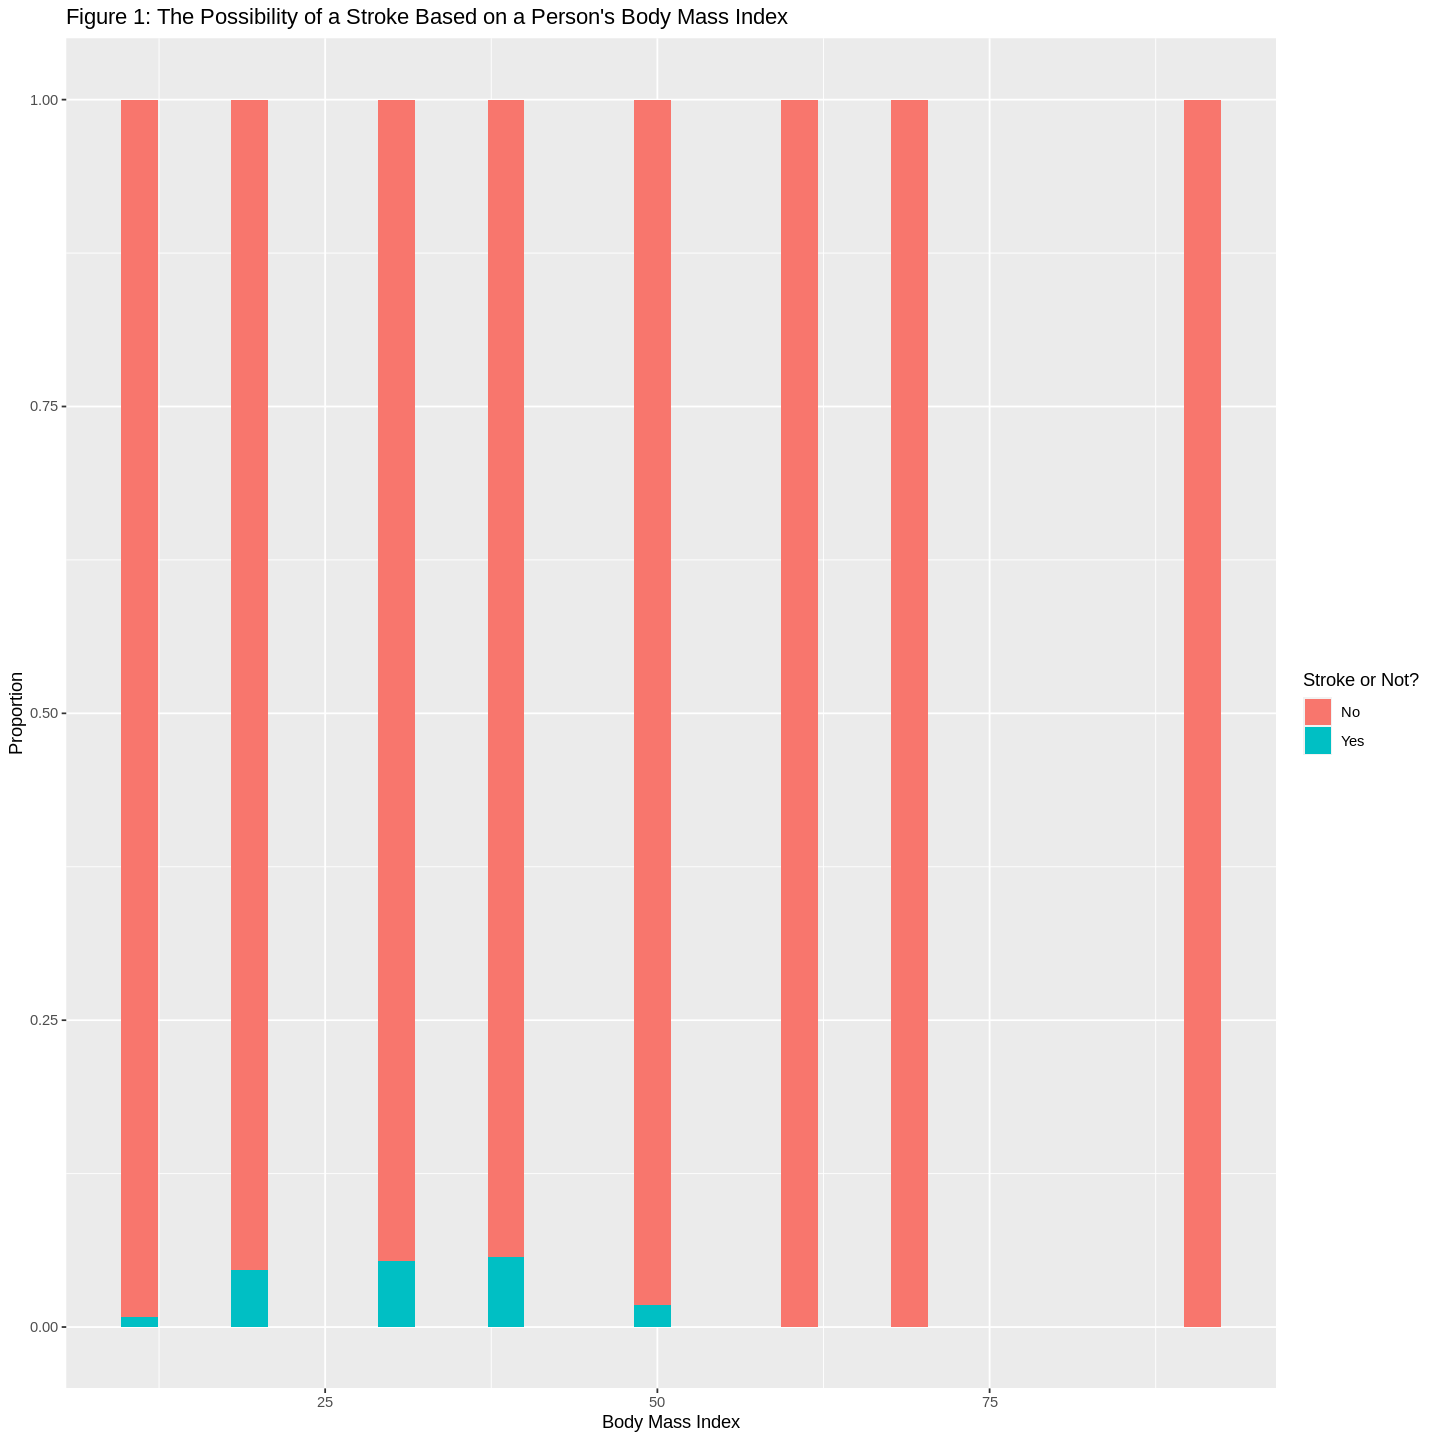

In [7]:
options(repr.plot.width=12, repr.plot.height=12)

# This is the frame that is only used for plotting
# It generalizes the bmi for plotting and convert stroke to char so that it can be used as the 'fill' argument.
stroke_train_for_plot <- stroke_train |>
    mutate(generalized_bmi = floor(floor(as.double(bmi))/10)*10) |>
    mutate(stroke_or_not = as.character(stroke))

# This bar graph visualizes the relationship between Body Mass Index and whether the person has a stroke or not
bmi_plot <- stroke_train_for_plot |>
    ggplot(aes(x = generalized_bmi, fill = stroke_or_not)) +
    geom_histogram(position = 'fill') +
    labs(fill = 'Stroke or Not?', x = 'Body Mass Index', y = 'Proportion') +
    ggtitle("Figure 1: The Possibility of a Stroke Based on a Person's Body Mass Index") +
    scale_fill_discrete(labels = c('No', 'Yes'))

bmi_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9236649,5,0.004159599,Preprocessor1_Model01
6,accuracy,binary,0.9516437,5,0.002994727,Preprocessor1_Model02
11,accuracy,binary,0.9546325,5,0.002294745,Preprocessor1_Model03
16,accuracy,binary,0.9549042,5,0.002365669,Preprocessor1_Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮
31,accuracy,binary,0.9549042,5,0.002365669,Preprocessor1_Model07
36,accuracy,binary,0.9549042,5,0.002365669,Preprocessor1_Model08
41,accuracy,binary,0.9549042,5,0.002365669,Preprocessor1_Model09
46,accuracy,binary,0.9549042,5,0.002365669,Preprocessor1_Model10


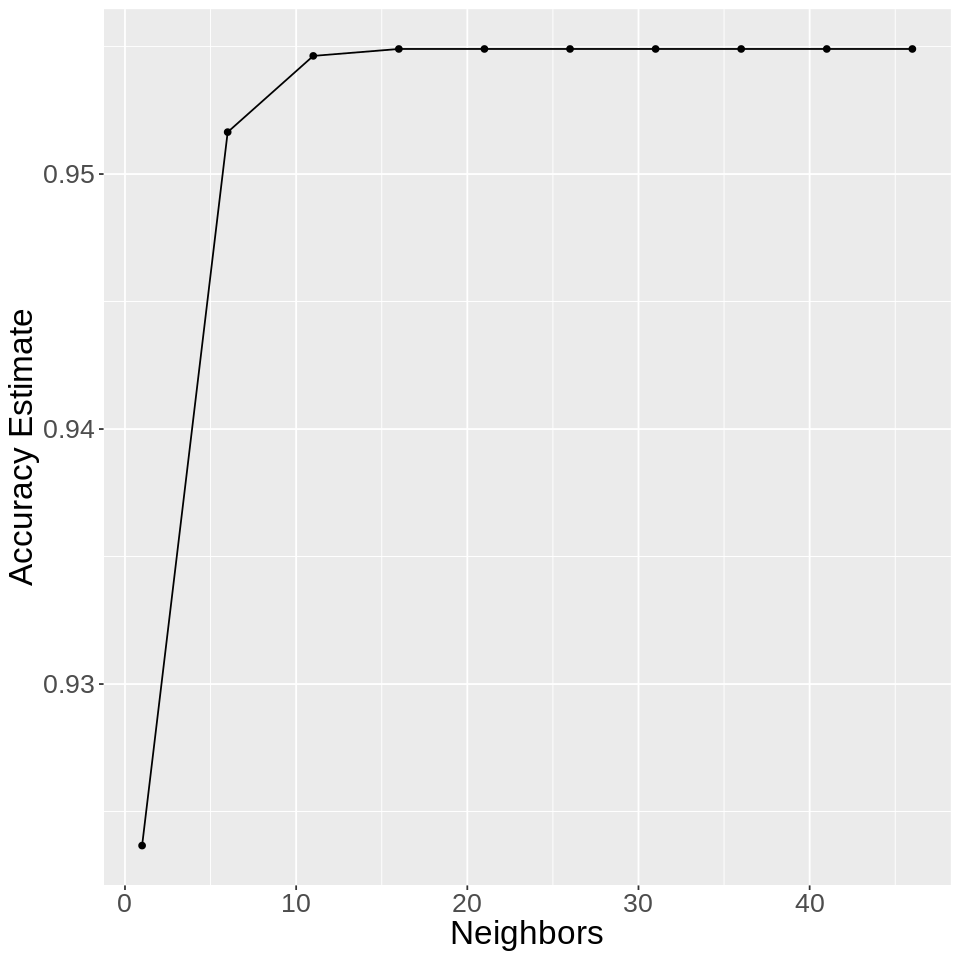

In [6]:
#performing 5-fold cross-validation
set.seed(8888)

options(repr.plot.height = 8, repr.plot.width = 8)

stroke_train <- stroke_train |>
    mutate(stroke = as.factor(stroke))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

stroke_recipe <- recipe(stroke ~ age + bmi + avg_glucose_level, data = stroke_train)

stroke_vfold <- vfold_cv(stroke_train, v = 5, strata = stroke)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

knn_results <- workflow() |>
  add_recipe(stroke_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = stroke_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

cross_validation_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))

cross_validation_plot

In [37]:
#retraining classifier with best K value
set.seed(1234)

stroke_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
       set_engine("kknn") |>
       set_mode("classification")


stroke_fit <- workflow() |>
             add_recipe(stroke_recipe) |>
             add_model(stroke_spec) |>
            fit(data = stroke_train)
stroke_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04563977
Best kernel: rectangular
Best k: 11

In [38]:
#evaluting classifiers accuracy on testing set
set.seed(1234)

stroke_test <- stroke_test |>
    mutate(stroke = as.factor(stroke))

stroke_predictions <- predict(stroke_fit, stroke_test) |>
                        bind_cols(stroke_test)

stroke_metrics <- stroke_predictions |>
    metrics(truth = stroke, estimate = .pred_class) |>
    filter(.metric == "accuracy")

stroke_metrics

stroke_conf_mat <- stroke_predictions |>
    conf_mat(truth = stroke, estimate = .pred_class)

stroke_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.963355


          Truth
Prediction    0    1
         0 1183   43
         1    2    0



*visualization results graph here*

### **Discussion:**

We did a study to see if age, BMI, and average glucose level could accuractly predict the risk of stroke at a high percentage level. We used a Stroke Prediction Dataset and split it into a 3:1 ratio training and testing set. Then we applied a 5-fold cross validation to determine the best k value. Afterwards, we retrained the model and assessed the model's accuracy by using the predict function on the testing set. Then we checked the accuracy of the model using a (blank) and a confusion matrix. Our model returned about a 96.34% accuracy, or in other words, 1183/1228 correct predictions. In our preliminary analysis, we found that all of our CV values are below 1, which means our data points have little variance, this gives us evidence to support our high accuracy.

We initially believed our classification model would return highly accurate prediction results as we preformed data anaylsis beforehand. Doing so allowed us to pick consistent variables that the model could use to classify data points. With that being said, there are still a number of things we could do to improve upon the 96.34% the model outputted. Since we are in a medical setting where we are predicting chances of stroke, we would want the model to be as accurate as possible to decrease harm among patients. In the future, we could add more variables for the model to go off of. Although smoking_status and heart_disease produced inconsistent results in the data analysis, we could test other variables we did not use such as ever_married and hypertension. Additionally, we could also perform more folds in cross-validation to reduce the standard error, but that involves more computation power and longer run times. Increasing the folds from 5 to 10 could potentially increase the classifiers accuracy.


The analysis of the Stroke Prediction Dataset can potentially provide insights into the risk factors associated with strokes. By examining multiple clinical features, the researchers can identify the most significant predictors of stroke occurrence, and develop a model that accurately predicts the likelihood of a stroke occurring in an individual.

The findings of such research can have significant implications for public health. Early detection and prevention can help reduce the number of fatalities associated with the condition. 

Analysis can also lead to future questions related to stroke prevention and treatment. For instance, the researchers can examine the effectiveness of existing stroke prevention measures and identify areas for improvement. Additionally, the findings can lead to the development of new treatment and prevention strategies that can further reduce the incidence of strokes.


### **References (APA):**



Fedesoriano. (2021, January 26). *Stroke Prediction Dataset*. Kaggle. Retrieved April 6, 2023, from https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download 

Heart and Stroke Foundation of Canada. (2022, December 20). *Stroke in Canada is on the rise*. Heart&Stroke . Retrieved April 6, 2023, from https://www.heartandstroke.ca/what-we-do/media-centre/news-releases/stroke-in-canada-is-on-the-rise#:~:text=A%20new%20study%20funded%20by,as%20well%20as%20better%20prevention. 

Katan, M., & Luft, A. (2018, May 23). *Global Burden of Stroke*. PubMed®. Retrieved April 6, 2023, from https://pubmed.ncbi.nlm.nih.gov/29791947/#:~:text=Stroke%20is%20the%20second%20leading,%2D%20and%20middle%2Dincome%20countries. 


